#### III.2. Model Calibration

Use singly-constrained model because the flows depend on the population(fixed) and the jobs(not fixed) in the destination would be better suited for the scenario testing where one parameter is fixed and the other is not.

We need to make the model as accurately predict the actually flow as possible.



In [2]:
# import all the necessary libraries
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit  
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
from math import sqrt
import statsmodels.formula.api as smf
from scipy.stats import norm
import networkx as nx

C:\Users\lenovo\AppData\Local\Temp\ipykernel_22236\2158460682.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df = pd.read_csv('London_flows.csv')
df.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


**Table 6. London Flows**

**Data Preprocessing**

drop the rows that is zero and in this case drop Battersea Park as it has no data for the flows.

In [4]:
df_drop = df[df['flows'] != 0]
df_drop.head()

,station_origin,station_destination,flows,population,jobs,distance
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560


**Table 7. London Flows Revised**

In [16]:
#Log
#df_drop['flow'] = df_drop['flows']
#df_drop['log_flow'] = np.log(df_drop['flow'])
#df_drop['dist'] = df_drop['distance'] + 1e-6 + 1
#df_drop['log_dist'] = np.log(df_drop['dist'])
#df_drop['log_jobs'] = np.log(df_drop['jobs'])
#df_origin = df_drop.copy()


In [8]:
print("variance of flows: ", df_origin['flows'].var())
print("variance of log_flow: ", df_origin['log_flow'].var())

variance of flows:  23804.54155601981
variance of log_flow:  2.55093809831381


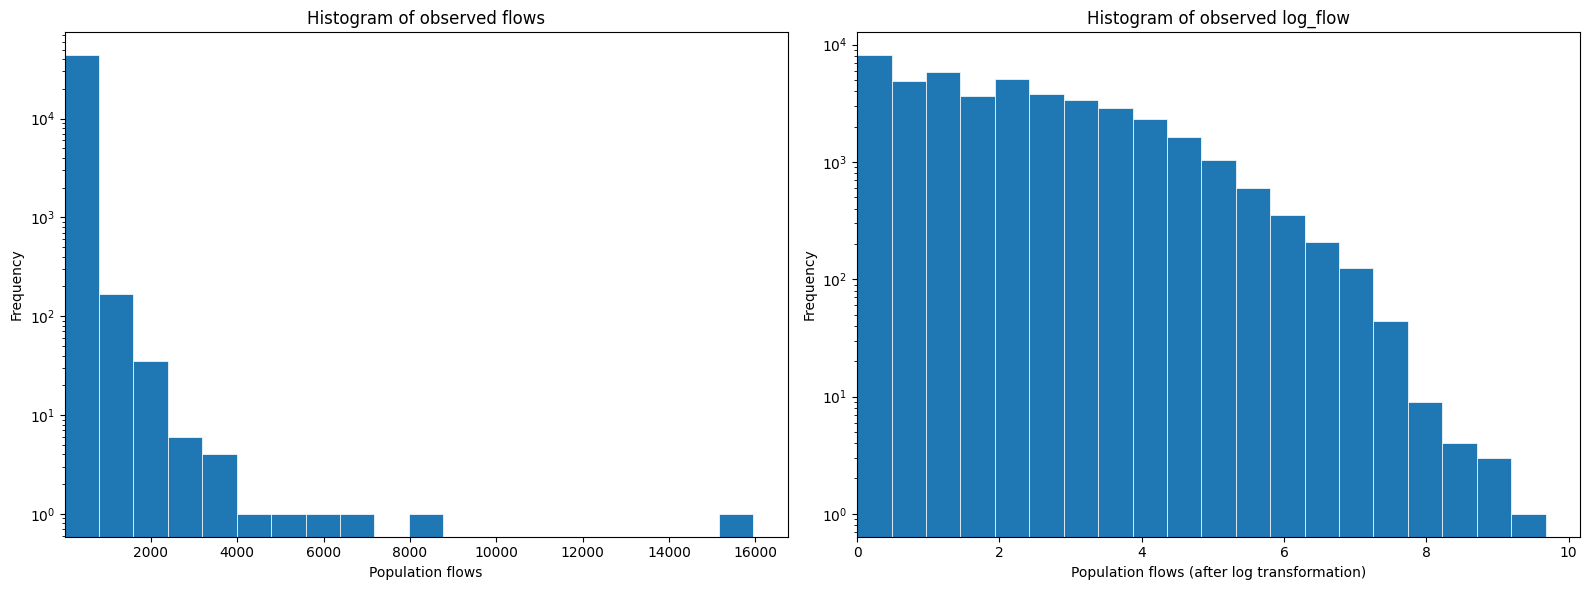

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))  # 1行2列的子图，整体图形大小为16x6

axes[0].hist(df_origin['flows'], bins=20, edgecolor='white', linewidth=0.5)
axes[0].set_title('Histogram of observed flows')
axes[0].set_yscale('log')
axes[0].set_xlabel('Population flows')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(left=1) 

axes[1].hist(df_origin['log_flow'], bins=20, edgecolor='white', linewidth=0.5)
axes[1].set_title('Histogram of observed log_flow')
axes[1].set_yscale('log')
axes[1].set_xlabel('Population flows (after log transformation)')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(left=0)  

plt.tight_layout()  
plt.show()

Figure 5. Traffic Flows Histograms of flows and logged flows

**Plot the log-log Flow Plot**

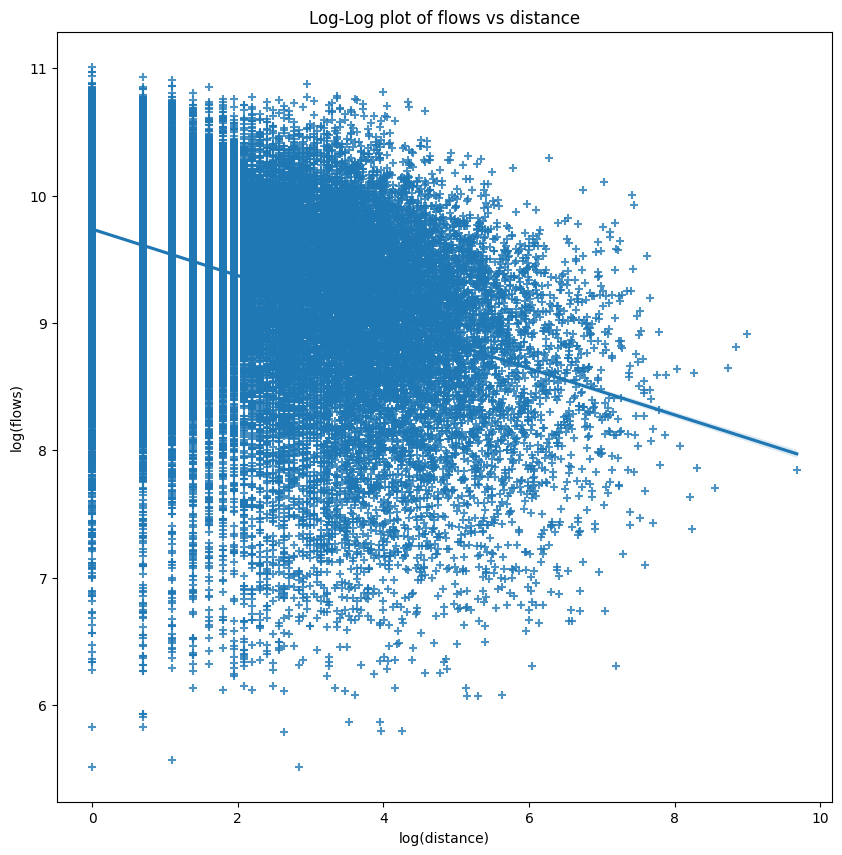

In [45]:
#subset the dataframe to the flows we want
cdata_flows = df_origin[["flows", "distance"]]
#remove all 0 values (logarithms can't deal with 0 values)
cdata_flows = cdata_flows[(cdata_flows!=0).all(1)]

#extract the x and y converting to log
x = np.log(cdata_flows["flows"])
y = np.log(cdata_flows["distance"])

#create the subplot
fig, ax = plt.subplots(figsize = (10,10))

#plot the results along with the line of best fit
sns.regplot(x=x, y=y, marker="+", ax=ax)

# set the title
ax.set_title("Log-Log plot of flows vs distance")
ax.set_xlabel("log(distance)")
ax.set_ylabel("log(flows)")
plt.show()

**Figure 5. Log-log Plot of Flows vs Distance**

In [11]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flow ~ station_origin + log_jobs + log_dist-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=df_drop, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
#print(prodSim.summary())

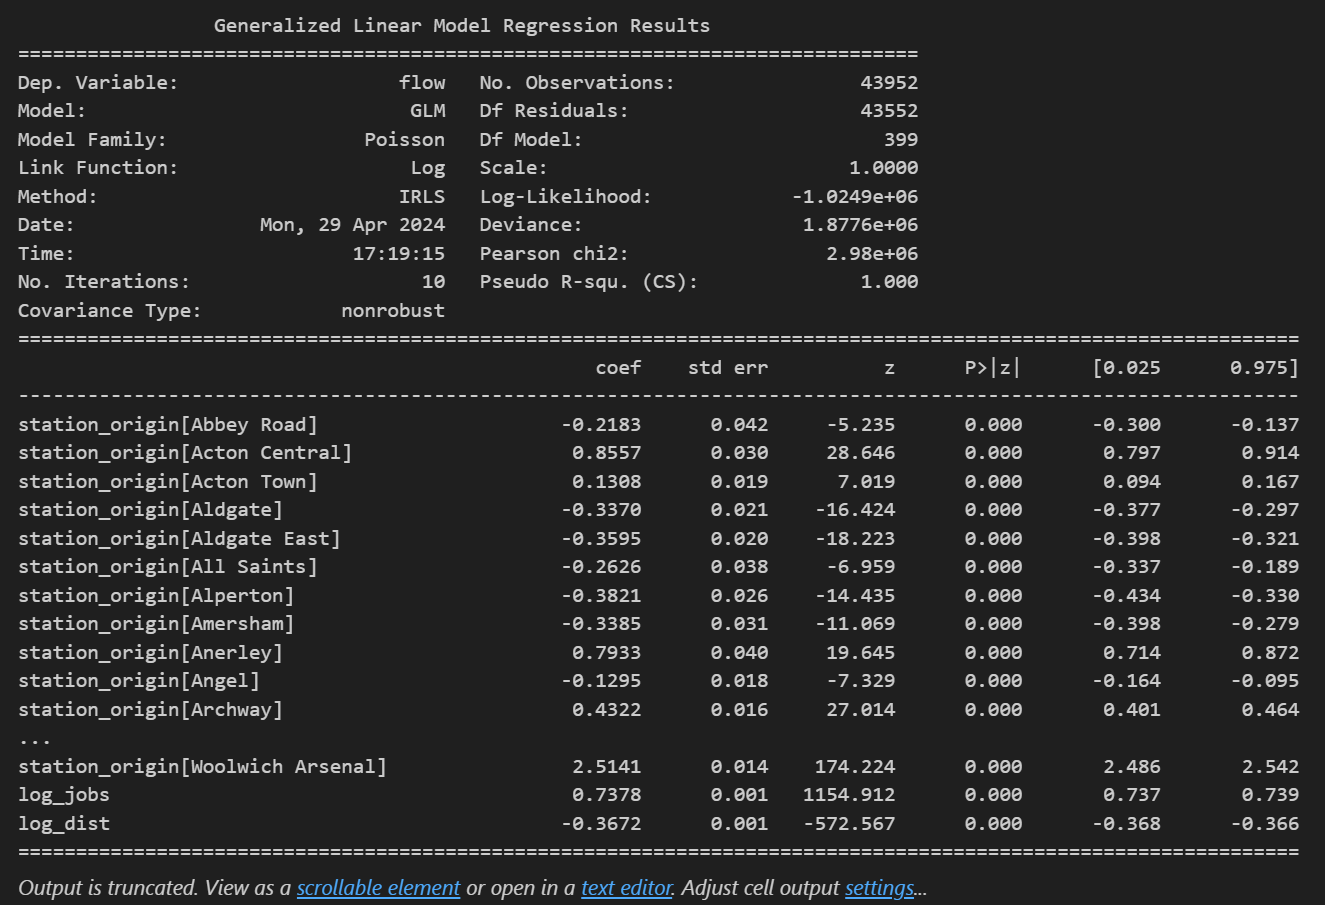

The $\gamma$ parameter related to the destination attractiveness: 0.7378

The $\beta$ distance decay parameter: -0.3672. 

P value shows all the explainatory variables are statistically significant <0.01. The z score indicates that the jobs have the most influence on the model.

In [12]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(df_drop.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
df_drop = df_drop.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(df_drop.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
df_drop = df_drop.merge(D_j, on = "station_destination", how = "left" )

C:\Users\lenovo\AppData\Local\Temp\ipykernel_22236\2847122089.py:3: FutureWarning: The provided callable <function sum at 0x0000019DFE55FBA0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  O_i = pd.DataFrame(df_drop.groupby(["station_origin"])["flows"].agg(np.sum))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_22236\2847122089.py:7: FutureWarning: The provided callable <function sum at 0x0000019DFE55FBA0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  D_j = pd.DataFrame(df_drop.groupby(["station_destination"])["flows"].agg(np.sum))


In [13]:
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
coefs
df_drop = df_drop.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
df_drop.drop(columns = ["coef"], inplace = True)
df_drop.head()

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs,O_i,D_j,alpha_i
0,Abbey Road,Beckton,1,599,442,8510.121774,1,0.000000,8511.121775,9.049129,6.091310,599,442,-0.21832
1,Abbey Road,Blackwall,3,599,665,3775.448872,3,1.098612,3776.448873,8.236539,6.499787,599,665,-0.21832
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.000000,5087.514221,8.534545,10.981421,599,58772,-0.21832
3,Abbey Road,Canning Town,37,599,15428,2228.923167,37,3.610918,2229.923168,7.709722,9.643939,599,15428,-0.21832
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,1,0.000000,6687.475561,8.807992,7.096721,599,1208,-0.21832


In [14]:
alpha_i = prodSim.params[0:-2]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

C:\Users\lenovo\AppData\Local\Temp\ipykernel_22236\1887813951.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = prodSim.params[-2]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_22236\1887813951.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -prodSim.params[-1]


In [15]:
df_drop["prodsimest1"] = np.exp(df_drop["alpha_i"]+gamma*df_drop["log_jobs"] 
                                 - beta*df_drop["log_dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
df_drop.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Beckton,1,599,442,8510.121774,1,0.000000,8511.121775,9.049129,6.091310,599,442,-0.21832,2.592975
1,Abbey Road,Blackwall,3,599,665,3775.448872,3,1.098612,3776.448873,8.236539,6.499787,599,665,-0.21832,4.723642
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.000000,5087.514221,8.534545,10.981421,599,58772,-0.21832,115.548339
3,Abbey Road,Canning Town,37,599,15428,2228.923167,37,3.610918,2229.923168,7.709722,9.643939,599,15428,-0.21832,58.310923
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,1,0.000000,6687.475561,8.807992,7.096721,599,1208,-0.21832,5.948552
5,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2,0.693147,8504.898910,9.048398,7.466228,599,1748,-0.21832,7.152677
6,Abbey Road,Cyprus,7,599,850,6532.099618,7,1.945910,6533.099619,8.784637,6.745236,599,850,-0.21832,4.629269
7,Abbey Road,Devons Road,1,599,611,3958.324171,1,0.000000,3959.324172,8.283829,6.415097,599,611,-0.21832,4.361126
8,Abbey Road,East India,2,599,1522,3384.141666,2,0.693147,3385.141667,8.127151,7.327781,599,1522,-0.21832,9.057944
9,Abbey Road,Island Gardens,2,599,691,7706.296370,2,0.693147,7707.296371,8.949923,6.538140,599,691,-0.21832,3.739332


**Assessing the model output**

To test the "Goodness-of-fit" of the model, check the coefficient of determination ($r^2$) or the Square Root of Mean Squared Error (RMSE). 

In [46]:
import scipy.stats

def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

In [47]:
def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

Flow - Distance:

In [48]:
best2_formula_double_sim_exp = "flow ~ station_origin + log_jobs + dist-1"

best2_double_sim_exp = smf.glm(formula=best2_formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

print("R-squared: ", CalcRSqaured(df_origin["flow"], best2_double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], best2_double_sim_exp.mu))

R-squared:  0.45590488914083815
RMSE:  114.37


Flow - Logged distance:

In [49]:
formula_double_sim_exp = "flow ~ station_origin + log_jobs + log_dist-1"

double_sim_exp = smf.glm(formula=formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

print("R-squared: ", CalcRSqaured(df_origin["flow"], double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], double_sim_exp.mu))

R-squared:  0.1683779372123963
RMSE:  152.287


**Logged flow - distance:**

In [50]:
best_formula_double_sim_exp = "log_flow ~ station_origin + log_jobs + dist-1"

best_double_sim_exp = smf.glm(formula=best_formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

# print
print("R-squared: ", CalcRSqaured(df_origin["log_flow"], best_double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], best_double_sim_exp.mu))

R-squared:  0.5387247573433747
RMSE:  1.088


**The r square is the biggest and the RMSE is the smallest, therefore this combination has the best performance. It is going to be used in the next question.**

Logged flow - logged distance:

In [51]:
formula_double_sim_exp = "log_flow ~ station_origin + log_jobs + log_dist-1"

double_sim_exp = smf.glm(formula=formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

# print
print("R-squared: ", CalcRSqaured(df_origin["log_flow"], double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], double_sim_exp.mu))

R-squared:  0.30449397993579636
RMSE:  1.44


#### IV.1. Scenario A: Job Decrease

 Cut half of the jobs in Canary  Wharf while conserving the number of people commuting: 

#### IV.2. Scenario B: Travel Cost Increase

Increase in travel cost can lead to decrease in the population parameter:
I don't know how to calculate it.

## Reference

Berche, B., C. von Ferber, T. Holovatch, and Yu. Holovatch. 2009. “Resilience of Public
Transport Networks against Attacks.” The European Physical Journal B 71 (1): 125–37.
https://doi.org/10.1140/epjb/e2009-00291-3.

Bloch, Francis, Matthew O. Jackson, and Pietro Tebaldi. 2019. “Centrality Measures in Networks.” SSRN Scholarly Paper ID 2749124. Rochester, NY: Social Science Research Network. https://doi.org/10.2139/ssrn.2749124

Bonacich, Phillip. 1987. “Power and Centrality: A Family of Measures.” American Journal of
Sociology 92 (5): 1170–82. https://doi.org/10.1086/228631.

Dijkstra, E.W. (1959). A note on two problems in connexion with graphs. Numer. Math. 1, 269–271 . https://doi.org/10.1007/BF01386390

Freeman, L. (1977): “A set of measures of centrality based on betweenness,” Sociometry,
40(1), 35–41.

Latora, Vito, and Massimo Marchiori. “Efficient behavior of small-world networks.” Physical Review Letters 87.19 (2001): 198701. <https://doi.org/10.1103/PhysRevLett.87.198701>

Nguyen, Quang & Khanh, Nguyen & Cassi, Davide & Bellingeri, Michele. (2021). New Betweenness Centrality Node Attack Strategies for Real-World Complex Weighted Networks.
Complexity. 2021. <https://doi.org/10.1155/2021/1677445.>

Wilson, A. G. (1971). ‘A Family of Spatial Interaction Models, and Associated 
Developments’. Environment and Planning A: Economy and Space. SAGE Publications Ltd, 
3 (1), pp. 1–32. doi: 10.1068/a030001.   